In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
# print(plt.style.available)
plt.style.use("ggplot")
# plt.style.use("fivethirtyeight")
plt.style.use("seaborn-talk")

from tqdm import tnrange, tqdm_notebook

In [2]:
class Base_MVDR(object):
    def __init__(self, vs):
        """
        Parameters
        ----------
        vs: Source manifold array vector
        """
        self.vs = vs
        self.weights_ = None
        
    def _compute_weights(self, training_data):
        n_training_samples = len(training_data)
        n_mics, snapshot = training_data[0].shape
        D = np.zeros((n_mics, n_training_samples), dtype=complex)
        for i_training_sample in range(n_training_samples):
            nv = training_data[i_training_sample]
            Rnhat = nv.dot(nv.transpose().conjugate()) / snapshot
            Rnhatinv = np.linalg.inv(Rnhat)
            w = Rnhatinv.dot(self.vs) / (self.vs.transpose().conjugate().dot(Rnhatinv).dot(self.vs))
            D[:, i_training_sample] = w.reshape(n_mics,)
        return D

    def _initialize(self, X):
        pass

    def _choose_weights(self, x):
        n_dictionary_atoms = self.weights_.shape[1]
        R = x.dot(x.transpose().conjugate())
        proxy = np.diagonal(self.weights_.transpose().conjugate().dot(R).dot(self.weights_))
        optimal_weight_index = np.argmin(proxy)
        return self.weights_[:, optimal_weight_index]
    
    def fit(self, training_data):
        """
        Parameters
        ----------
        X: shape = [n_samples, n_features]
        """
        D = self._compute_weights(training_data)
        self.weights_ = D
        return self

    def choose_weights(self, x):
        return self._choose_weights(x)

#### Setup

In [3]:
# Uniform Linear Array (ULA)
n_mics = 10
d = 0.5
d_array = d*np.arange(-(n_mics-1)/2, (n_mics-1)/2+1).reshape(n_mics, 1)
us = 0
vs = np.exp(1j*2*np.pi*d_array*us)

SNRs = np.arange(0, 31, 10)
n_SNRs = len(SNRs)
sigma_n = 1

#### Training data

In [4]:
n_training_samples = 5000
training_snapshots = [10, 50, 100, 1000]
sigma = 10**(20/10)
training_noise_interference_data_various_snapshots = []
for training_snapshot in training_snapshots:
    training_noise_interference_data = []
    for i_training_sample in range(n_training_samples):
        u = np.random.uniform(0, 1)
        vi = np.exp(1j*2*np.pi*d_array*u)
        ii = np.sqrt(sigma/2)*np.random.randn(1, training_snapshot) + 1j*np.sqrt(sigma/2)*np.random.randn(1, training_snapshot) # interference samples
        noise = np.sqrt(sigma_n/2)*np.random.randn(n_mics, training_snapshot) + 1j*np.sqrt(sigma_n/2)*np.random.randn(n_mics, training_snapshot) # Gaussian noise samples
        nv = vi*ii + noise
        training_noise_interference_data.append(nv)
    training_noise_interference_data_various_snapshots.append(training_noise_interference_data)

#### Train baseline dictionary

In [5]:
dictionaries = []
for i_training_snapshot in range(len(training_snapshots)):
    training_noise_interference_data = training_noise_interference_data_various_snapshots[i_training_snapshot]
    dictionary = Base_MVDR(vs)
    dictionary.fit(training_noise_interference_data);
    dictionaries.append(dictionary)

#### Testing

In [6]:
n_trials = 200
snapshots = np.array([10, 20, 30, 40, 60, 100, 200, 500, 1000])
n_snapshots = len(snapshots)
ui1 = np.random.uniform(0, 1)
ui2 = np.random.uniform(0, 1)
sigma_1 = 10**(20/10)
sigma_2 = 0*10**(20/10)
vi1 = np.exp(1j*2*np.pi*d_array*ui1)
vi2 = np.exp(1j*2*np.pi*d_array*ui2)
Rn = sigma_1*vi1.dot(vi1.transpose().conjugate()) + sigma_2*vi2.dot(vi2.transpose().conjugate()) + sigma_n*np.identity(n_mics)
Rninv = np.linalg.inv(Rn)
Wo = Rninv.dot(vs) / (vs.transpose().conjugate().dot(Rninv).dot(vs))

sinr_snr_mvdr = np.zeros((n_SNRs, n_snapshots))
sinr_snr_mpdr = np.zeros((n_SNRs, n_snapshots))
sinr_snr_baseline_mpdr = np.zeros((len(training_snapshots), n_SNRs, n_snapshots))

for i_SNR in tqdm_notebook(range(n_SNRs), desc="SNRs"):
    sigma_s = 10**(SNRs[i_SNR] / 10)
    Rs = sigma_s * vs.dot(vs.transpose().conjugate())
    
    SINRopt = ( np.real(Wo.transpose().conjugate().dot(Rs).dot(Wo)) / np.real(Wo.transpose().conjugate().dot(Rn).dot(Wo)) )[0][0]
    
    for i_snapshot in tqdm_notebook(range(n_snapshots), desc="Snapshots", leave=False):
        snapshot = snapshots[i_snapshot]
        sinr_mvdr = np.zeros(n_trials)
        sinr_mpdr = np.zeros(n_trials)
        sinr_baseline_mpdr = np.zeros((len(training_snapshots), n_trials))
        
        for i_trial in range(n_trials):
            ss = np.sqrt(sigma_s/2)*np.random.randn(1, snapshot) + 1j*np.sqrt(sigma_s/2)*np.random.randn(1, snapshot) # signal samples
            ii1 = np.sqrt(sigma_1/2)*np.random.randn(1, snapshot) + 1j*np.sqrt(sigma_1/2)*np.random.randn(1, snapshot) # first interference samples
            ii2 = np.sqrt(sigma_2/2)*np.random.randn(1, snapshot) + 1j*np.sqrt(sigma_1/2)*np.random.randn(1, snapshot) # second interference samples
            nn = np.sqrt(sigma_n/2)*np.random.randn(n_mics, snapshot) + 1j*np.sqrt(sigma_n/2)*np.random.randn(n_mics, snapshot) # Gaussian noise samples
            
            sv = vs*ss
            nv = vi1*ii1 + vi2*ii2 + nn
            xx = sv + nv
            
            Rnhat = nv.dot(nv.transpose().conjugate()) / snapshot
            Rxhat = xx.dot(xx.transpose().conjugate()) / snapshot
            
            Rnhatinv = np.linalg.inv(Rnhat)
            Rxhatinv = np.linalg.inv(Rxhat)
            
            wv = Rnhatinv.dot(vs) / (vs.transpose().conjugate().dot(Rnhatinv).dot(vs))
            wp = Rxhatinv.dot(vs) / (vs.transpose().conjugate().dot(Rxhatinv).dot(vs))
            for i_dictionary in range(len(dictionaries)):
                dictionary = dictionaries[i_dictionary]
                w_baseline_p = dictionary.choose_weights(xx)
                sinr_baseline_mpdr[i_dictionary, i_trial] = np.real(w_baseline_p.transpose().conjugate().dot(Rs).dot(w_baseline_p)) / np.real(w_baseline_p.transpose().conjugate().dot(Rn).dot(w_baseline_p)) / SINRopt
                
            sinr_mvdr[i_trial] = np.real(wv.transpose().conjugate().dot(Rs).dot(wv)) / np.real(wv.transpose().conjugate().dot(Rn).dot(wv)) / SINRopt
            sinr_mpdr[i_trial] = np.real(wp.transpose().conjugate().dot(Rs).dot(wp)) / np.real(wp.transpose().conjugate().dot(Rn).dot(wp)) / SINRopt
            
        sinr_snr_mvdr[i_SNR, i_snapshot] = np.sum(sinr_mvdr) / n_trials
        sinr_snr_mpdr[i_SNR, i_snapshot] = np.sum(sinr_mpdr) / n_trials
        for i_dictionary in range(len(dictionaries)):
            sinr_snr_baseline_mpdr[i_dictionary, i_SNR, i_snapshot] = np.sum(sinr_baseline_mpdr[i_dictionary, :]) / n_trials

#### Visualize results

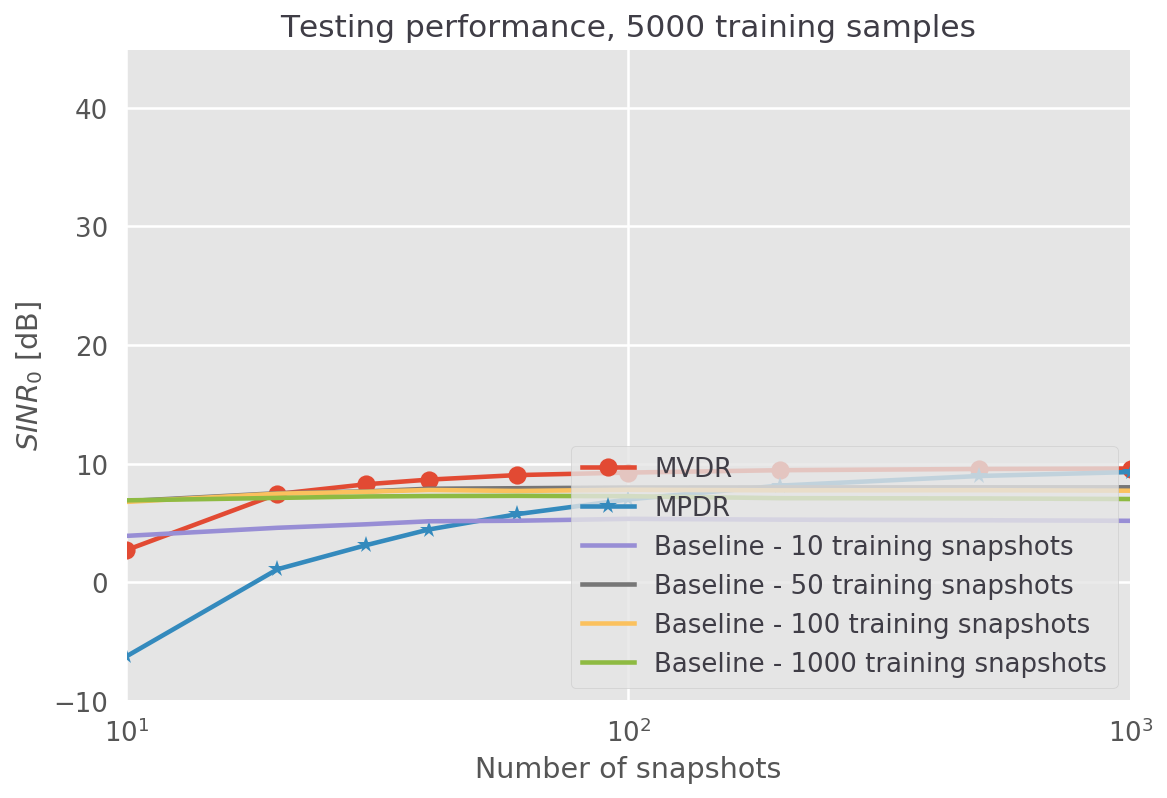

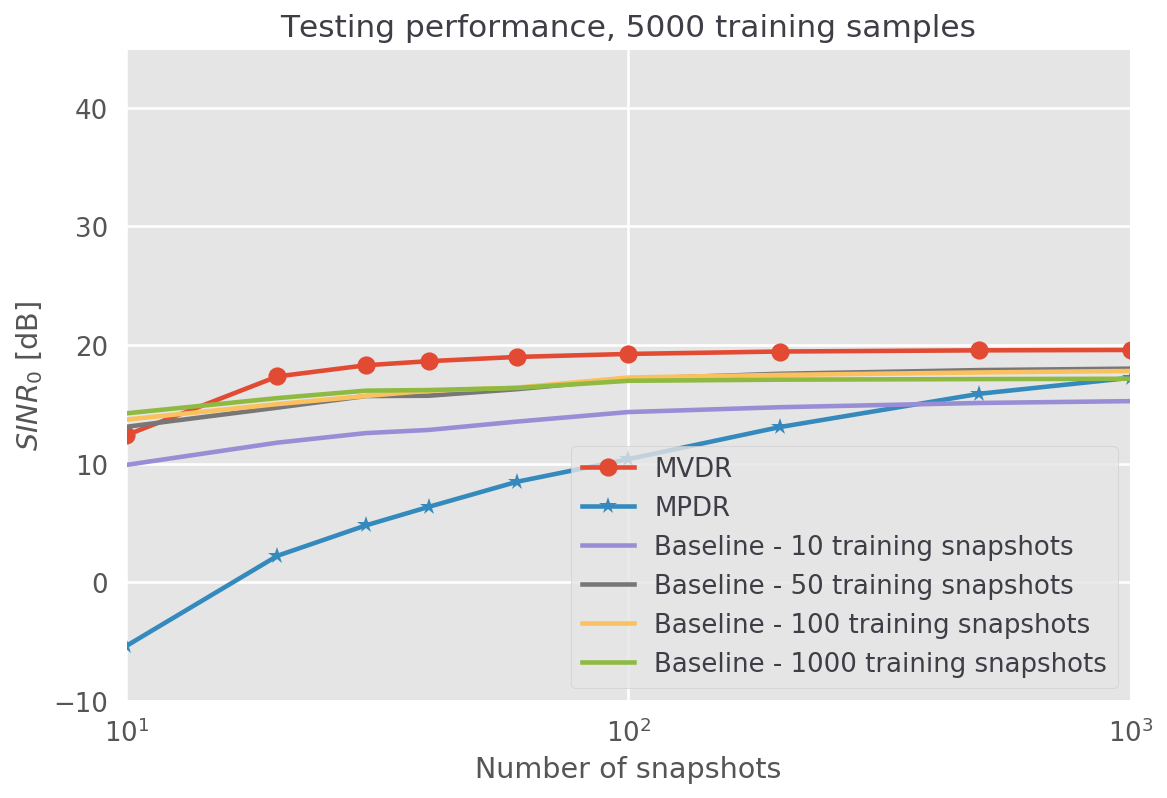

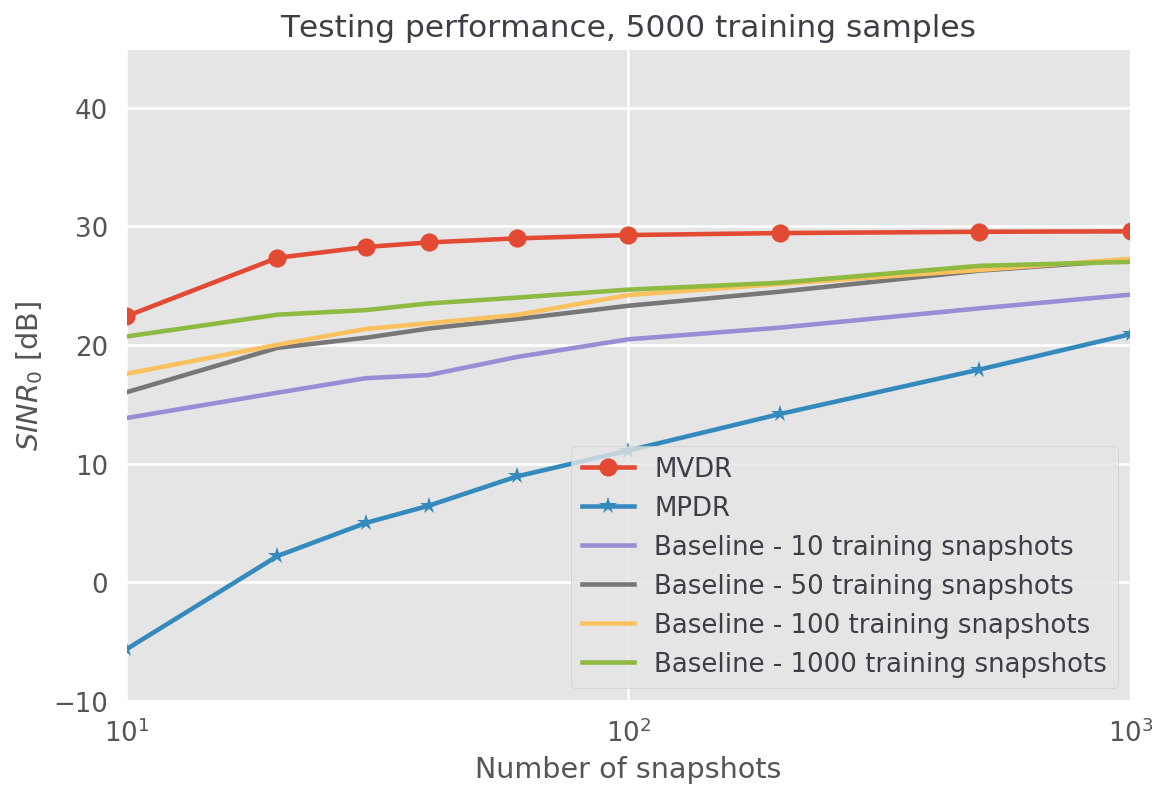

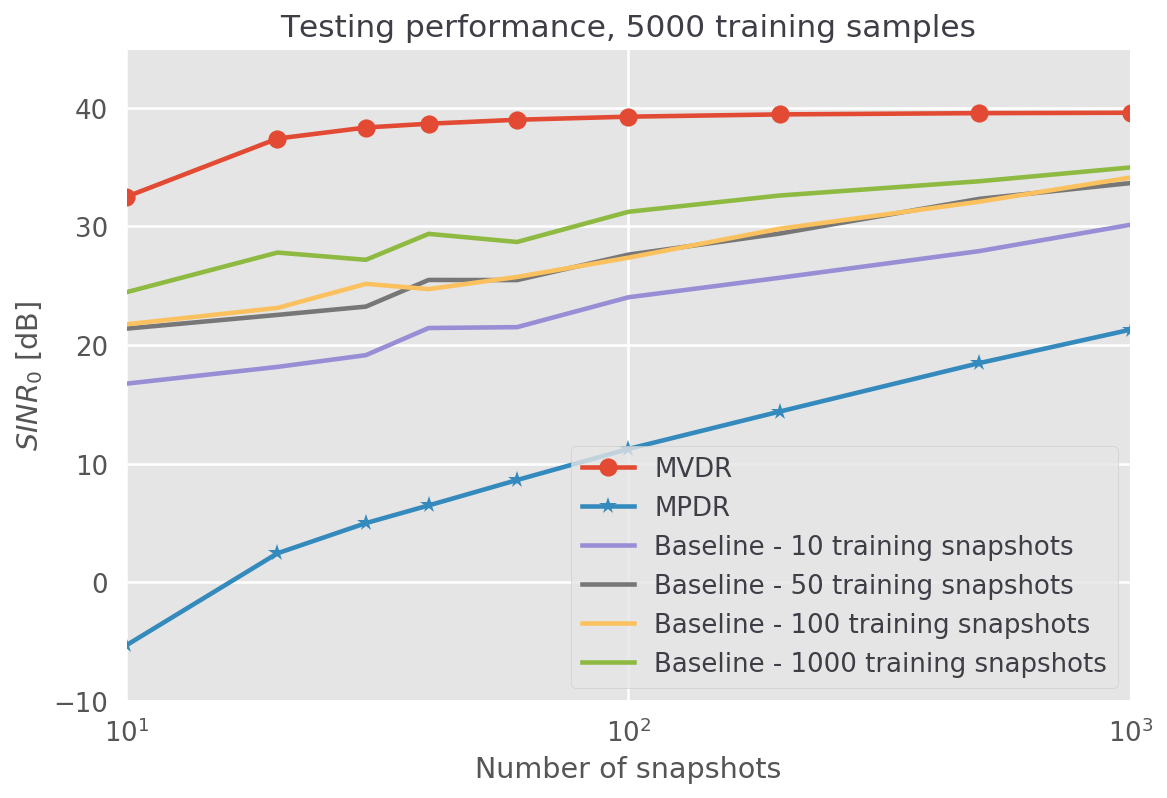

In [7]:
for i_SNR in range(n_SNRs):
    sigma_s = 10**(SNRs[i_SNR] / 10)
    Rs = sigma_s * vs.dot(vs.transpose().conjugate())
    
    SINRopt = ( np.real(Wo.transpose().conjugate().dot(Rs).dot(Wo)) / np.real(Wo.transpose().conjugate().dot(Rn).dot(Wo)) )[0][0]
    fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
    ax.semilogx(snapshots, 10*np.log10(sinr_snr_mvdr[i_SNR, :]*SINRopt), marker="o", label="MVDR")
    ax.semilogx(snapshots, 10*np.log10(sinr_snr_mpdr[i_SNR, :]*SINRopt), marker="*", label="MPDR")
    for i_training_snapshot in range(len(training_snapshots)):
        ax.semilogx(snapshots, 10*np.log10(sinr_snr_baseline_mpdr[i_training_snapshot, i_SNR, :]*SINRopt), 
                    label="Baseline - {} training snapshots".format(training_snapshots[i_training_snapshot]))
    ax.set_xlim(10, 1000); ax.set_ylim(-10, 45)
    ax.legend(loc="lower right")
    ax.set_xlabel("Number of snapshots")
    ax.set_ylabel(r"$SINR_0$ [dB]")
    ax.set_title("Testing performance, {} training samples".format(n_training_samples))

In [8]:
SINRopt

9938.126904278122